In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;} </style>""")

In [2]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
from datetime import datetime, timedelta
print("Libraries imported correctly")
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import DivergingNorm
# from scipy.signal import convolve2d
# import import_ipynb
# import Functions

Libraries imported correctly


In [2]:
# Other settings
qs.extend_pandas()

# Settings for plot visualization
plt.style.use('seaborn-darkgrid')

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = 0.3
#plt.rcParams['legend.facecolor'] = '#2f3540'
plt.rcParams['ytick.labelright'] = plt.rcParams['ytick.right'] = True
plt.rcParams['lines.linewidth'] = 0.9
plt.rcParams['lines.markersize'] = 0.5

np.set_printoptions(edgeitems=40, linewidth=1000)

pd.set_option("display.precision", 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print("Notebook parameters set correctly")

NameError: name 'qs' is not defined

In [3]:
%run Functions.ipynb

In [4]:
ini_equity = 100
commision = 0.000111538462 # 0.001 = 0.1% of the daily return

## Download data from SP500

In [5]:
#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data.shape
from_date = '2020-01-01'

data = data.loc[from_date:, ['Open', 'Close']].copy()
data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.drop(['Open'], axis=1)
data.index
#data.style.set_table_attributes('style="font-size: 15px"')

(17792, 5)

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
               ...
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16'], dtype='datetime64[ns]', name='Date', length=179, freq=None)

In [6]:
# heading_properties = [('font-size', '18px')]

# cell_properties = [('font-size', '16px')]

# dfstyle = [dict(selector="th", props=heading_properties),\
#  dict(selector="td", props=cell_properties)]

# data.style.set_table_styles(dfstyle)

In [7]:
data.head()

,Close,Market_daily_ret
Date,,
2020-01-02,3257.850098,0.004062
2020-01-03,3234.850098,-0.007060
2020-01-06,3246.280029,0.003533
2020-01-07,3237.179932,-0.002803
2020-01-08,3253.050049,0.004902


In [8]:
data.tail()

,Close,Market_daily_ret
Date,,
2020-09-10,3339.189941,-0.017585
2020-09-11,3340.969971,0.000533
2020-09-14,3383.540039,0.012742
2020-09-15,3401.199951,0.005219
2020-09-16,3412.679932,0.003375


<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

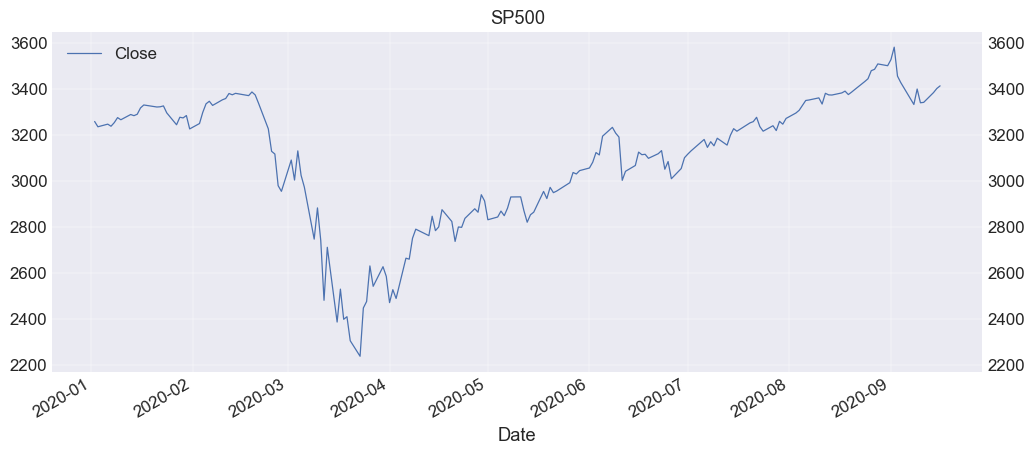

In [9]:
data['Close'].plot(legend=True, title="SP500")

In [10]:
#data.loc['2020', 'Close'].plot(legend=True, title="SP500 in 2020")

## Walk-Forward Optimization

### Define values of Moving Averages and time periods for optimization

In [11]:
%run Functions.ipynb

In [16]:
# fast_ma_list = [1, 3, 5, 10, 15, 20, 25]
# slow_ma_list = [5, 10, 20, 40, 60, 80, 100]

fast_ma_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
slow_ma_list = [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]

IS_start_years = pd.date_range(start='1950-01-01', end='2017-01-01', freq='1YS', closed=None)
IS_end_years = pd.date_range(start='1952-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start_years = pd.date_range(start='1953-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end_years = pd.date_range(start='1953-12-31', end='2020-12-31', freq='1Y', closed=None)

# IS_start_years = pd.date_range(start='2010-01-01', end='2017-01-01', freq='1YS', closed=None)
# IS_end_years = pd.date_range(start='2012-12-31', end='2019-12-31', freq='1Y', closed=None)
# OOS_start_years = pd.date_range(start='2013-01-01', end='2020-01-01', freq='1YS', closed=None)
# OOS_end_years = pd.date_range(start='2013-12-31', end='2020-12-31', freq='1Y', closed=None)

num_neighbors_matrix = get_num_neighbors(fast_ma_list, slow_ma_list)

print("Number of windows: {}\nNumber of optimizations per period: {}".format(len(IS_start_years), len(fast_ma_list)*len(slow_ma_list)))
#print_periods(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years)

Number of windows: 68
Number of optimizations per period: 225


### Optimization

In [17]:
%%time
%run Functions.ipynb

CPU times: user 42.9 ms, sys: 2.75 ms, total: 45.7 ms
Wall time: 44 ms


In [20]:
%%time
%run Functions.ipynb
df = data[IS_start_years[0]:OOS_end_years[-1]].copy()

last_position = 0 # We suppose that we start not being invested. 1:long, -1:short

market_pln = []
oos_pln = []
market_sr = []
oos_sr = []
market_max_dd = []
oos_max_dd = []
best_combinations = []
robust_sharpe_results_list = []

# Create necessary columns 
cols = ['Strat_daily_ret', 'Strat_position', 'Long_only', 'Costs', 'Market_cum_ret']
df = pd.concat([df, pd.DataFrame(columns=cols)])

for IS_start, IS_end, OOS_start, OOS_end in zip(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years):
    results_pnl = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    results_sharpe = np.zeros((len(fast_ma_list),len(slow_ma_list)))

    in_sample = df.loc[IS_start:IS_end].copy()
    oos_sample = df.loc[OOS_start:OOS_end].copy()
    
    ############################################ IN SAMPLE  ############################################
    results_pnl, results_sharpe, market_sharpe = run_all_combinations(in_sample, fast_ma_list, slow_ma_list)
    title = "Individual SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    #show_heatmap(results_sharpe, market_sharpe, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    
    # Get index of maximum SR for the In-Sample period
    fast_index, slow_index, robust_results_sharpe = get_best_combination(market_sharpe, results_sharpe, num_neighbors_matrix, allow_long_only=True)
    title = "Robust SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    show_heatmap(robust_results_sharpe, market_sharpe, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    
    print("Best In-sample performance:")
    print_backtest_stats_ma(in_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], ret_strat=results_pnl[fast_index, slow_index], sr_strat=results_sharpe[fast_index, slow_index])
    
    ############################################ OUT OF SAMPLE  ############################################
    print("OOS performance:")
    _, pnl_sp, sharpe_sp = backtest_strat_ma(oos_sample, fast_ma=0, slow_ma=0, last_position=1) # Market- always long
    _, pnl, sharpe = backtest_strat_ma(oos_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], last_position=last_position)
    print_backtest_stats_ma(oos_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], pnl, sharpe)  

    ############################################ Save metrics  ############################################
    robust_sharpe_results_list.append(robust_results_sharpe)
    best_combinations.append([fast_ma_list[fast_index], slow_ma_list[slow_index]])
    market_max_dd.append(oos_sample['Market_daily_ret'].max_drawdown())
    oos_max_dd.append(oos_sample['Strat_daily_ret'].max_drawdown())
    market_pln.append(pnl_sp)
    market_sr.append(sharpe_sp)
    oos_pln.append(pnl)
    oos_sr.append(sharpe)
    
    # Save come columns from OOS
    df.loc[OOS_start:OOS_end, cols] = oos_sample[cols]
    print()
    
print("End of optimization")

KeyError: NaT

### Check chosen MA combinations

### Plot OOS of Strategy vs Benchmark

,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Fast_ma,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,25,1,1,1,1,1,1,1,1,65,1,65,65,1,35,30,65,1,0,0,0,35,65,0,1,0,0,50,50,55,50,50,0,0,30,35,5,45,45,50,0,55,0,20,25,1
Slow_ma,20,5,5,140,10,20,20,5,5,10,10,10,10,5,5,5,5,5,5,5,5,5,260,5,100,5,5,5,5,5,5,140,220,180,180,20,40,40,100,260,0,0,0,80,220,0,5,0,0,260,260,220,240,240,0,0,240,220,100,120,120,140,0,60,0,60,40,10
Long_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0


0    58
1    10
Name: Long_only, dtype: int64

1     33
0     10
65     5
50     5
35     3
55     2
45     2
30     2
25     2
3      2
20     1
5      1
Name: Fast_ma, dtype: int64

5      21
0      10
10      6
220     4
20      4
260     4
240     3
100     3
40      3
140     3
120     2
60      2
180     2
80      1
Name: Slow_ma, dtype: int64

<AxesSubplot:title={'center':'Best MA combination chosen'}>

<AxesSubplot:>

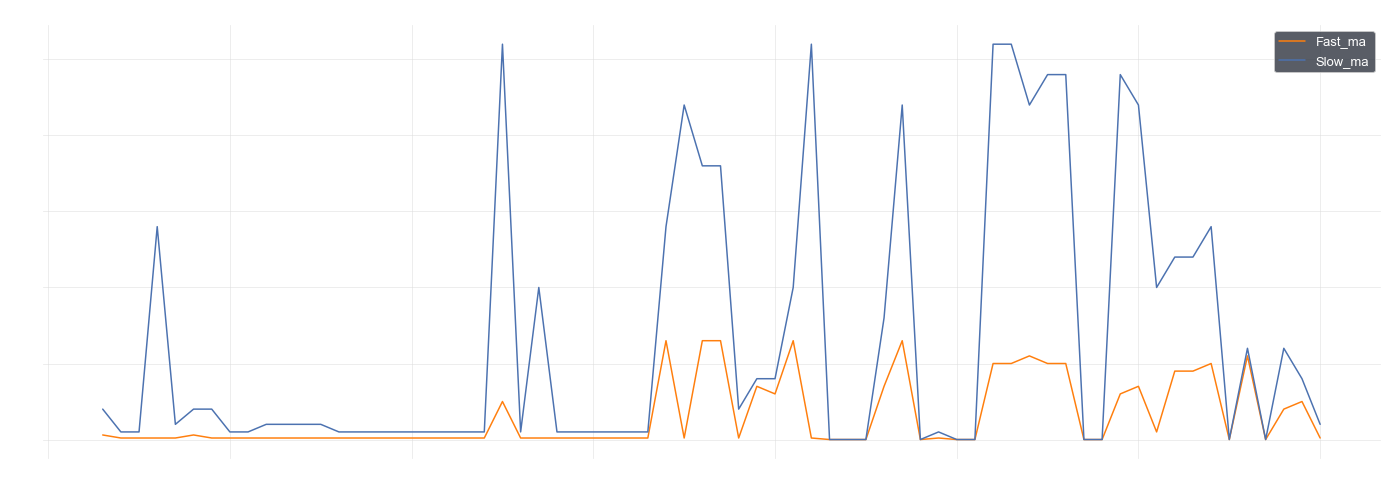

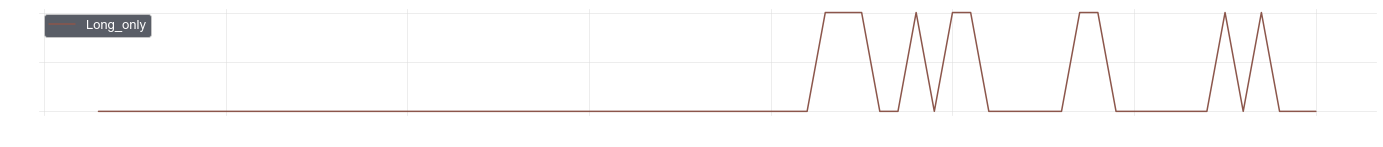

In [16]:
bests = pd.DataFrame(best_combinations, columns=['Fast_ma', 'Slow_ma'], index=OOS_start_years.year)
bests[['Fast_ma', 'Slow_ma']] = bests[['Fast_ma', 'Slow_ma']].where(bests['Fast_ma'] != bests['Slow_ma'], other=0)
bests['Long_only'] = np.where(bests['Fast_ma'] == bests['Slow_ma'], 1, 0)
bests.T
bests['Long_only'].value_counts()
bests['Fast_ma'].value_counts()
bests['Slow_ma'].value_counts()
bests[['Fast_ma', 'Slow_ma']].plot(figsize=(24,8), color=('tab:orange', 'b'), title="Best MA combination chosen")
bests[['Long_only']].plot(figsize=(24,2), color='tab:brown')
#bests.plot(secondary_y=['Long_only'], color=('tab:orange', 'b', 'tab:brown'))

,Close,Market_daily_ret,Strat_daily_ret,Strat_position,Long_only,Costs,Market_cum_ret,Strat_cum_ret
1953-01-02,26.540001,-0.001129,-0.000112,1,0,0.000111538,99.887095,99.988846
2020-09-03,3455.060059,-0.035126,-0.035237,0,0,0.000111538,13003.613467,40655.337140


0    17036
Name: Long_only, dtype: int64

1    11774
0     5262
Name: Strat_position, dtype: int64

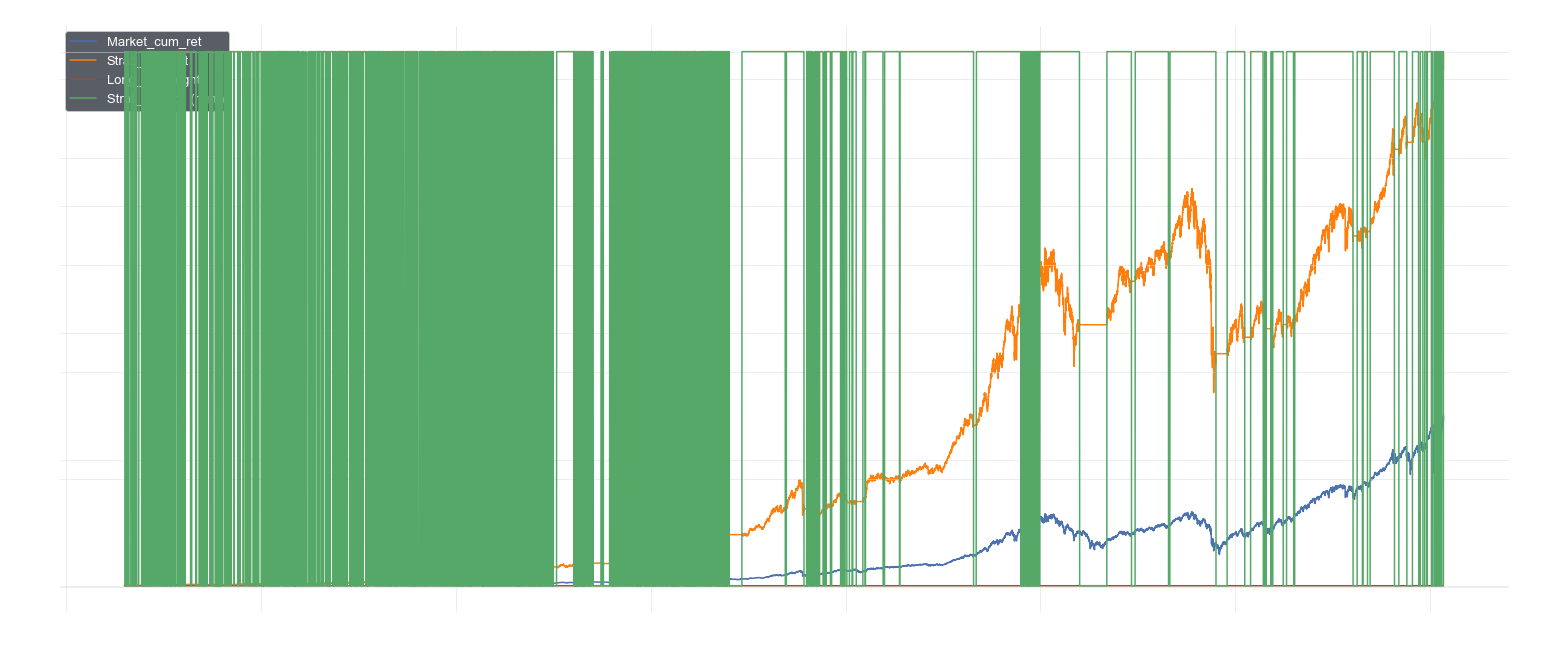

In [17]:
results_df = prepare_oos_df(df.loc[OOS_start_years[0]:OOS_end_years[-1]].copy())
results_df.iloc[[0,-1]]
results_df['Long_only'].value_counts()
results_df['Strat_position'].value_counts()
show_oos_plot(results_df)

### Save metrics from the optimization

In [18]:
results_df.to_csv('Strategy returns.csv')

In [19]:
metrics = ['PNL', 'SR', 'MAX_DD']
index = pd.MultiIndex.from_product([['SP500', 'Strategy']], names=['Asset'])
columns = pd.MultiIndex.from_product([[], metrics], names=['Year', 'Metric'])

metrics_df = pd.DataFrame([], index=index, columns=columns)

for i, year in enumerate(OOS_start_years.year):
    year_sp_pln = market_pln[i]
    year_oos_pln = oos_pln[i]
    year_sp_sr = market_sr[i]
    year_oos_sr = oos_sr[i]
    year_sp_dd = market_max_dd[i]
    year_oos_dd = oos_max_dd[i]
    
    year_data = [[year_sp_pln, year_sp_sr, year_sp_dd], [year_oos_pln, year_oos_sr, year_oos_dd]]
    
    metrics_df = add_data(metrics_df, year_data, year)

metrics_df

Year           1953                            1954                            1955                            1956                           1957                            1958                            1959                            1960                            1961                            1962                            1963                            1964                            1965                            1966                            1967                            1968                            1969                            1970                            1971                            1972                            1973                            1974                            1975                            1976                           1977                            1978                            1979                            1980                           1981                            1982                            1983                      \
Metric          PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD   
Asset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
SP500     93.375987 -0.671338 -0.148162  145.022170  3.999324 -0.044217  126.403558  1.604449 -0.105851  102.616532  0.270385 -0.105963  85.686744 -1.124333 -0.206595  138.059507  3.637708 -0.043570  108.476726  0.909491 -0.091748   97.027886 -0.238671 -0.135618  123.128553  2.124493 -0.062318   88.190071 -0.676879 -0.264445  118.890647  2.058319 -0.065387  112.969880  2.335873 -0.035466  109.061947  1.285378 -0.096045   86.909014 -1.130484 -0.221773  120.092119  2.232168 -0.066093  107.660412  0.923809 -0.093052   88.638549 -1.160846 -0.159759  100.097767  0.081631 -0.258613  110.786755  1.049972 -0.139448  115.633272  1.872231 -0.051355   82.634477 -1.126119 -0.233533   70.281902 -1.500315 -0.375952  131.549016  1.847720 -0.141408  119.148460  1.627096 -0.083650  88.498045 -1.300780 -0.152243  101.062042  0.146459 -0.135527  112.308815  1.120375 -0.102453  125.773570  1.469919 -0.170719  90.269599 -0.690813 -0.183536  114.761319  0.841849 -0.165553  117.271042  1.257962 -0.069068   


Year,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Asset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SP500,93.375987,145.022170,126.403558,102.616532,85.686744,138.059507,108.476726,97.027886,123.128553,88.190071,118.890647,112.969880,109.061947,86.909014,120.092119,107.660412,88.638549,100.097767,110.786755,115.633272,82.634477,70.281902,131.549016,119.148460,88.498045,101.062042,112.308815,125.773570,90.269599,114.761319,117.271042,101.400602,126.333408,114.620409,102.027503,112.400841,127.250465,93.440862,126.306703,104.464263,107.055156,98.460709,134.110655,120.263666,131.008182,126.668589,119.526047,89.860815,86.957307,76.634036,126.380400,108.993452,103.001023,113.619432,103.529573,61.514207,123.45419,112.782714,99.996816,113.405691,129.601250,111.390634,99.273400,109.535023,119.419966,93.762740,128.878070,110.083944
Strategy,98.290534,135.995622,117.234278,93.938309,97.669716,121.258997,105.309000,113.261917,114.503749,118.552237,115.661999,111.918722,110.478287,112.773926,124.723909,121.652098,111.015456,122.482770,124.439617,121.549742,105.071948,104.911288,107.485031,115.636819,93.637211,119.435418,114.930523,127.391401,98.228648,125.987345,105.099610,100.043688,127.747741,116.437435,99.648970,99.000407,118.559661,97.238814,122.275186,102.253566,107.124347,98.663364,134.142430,110.908173,131.656523,126.055639,111.066806,90.717060,89.455211,100.000000,117.075524,103.676820,103.832595,109.128171,103.642258,62.408388,112.99474,101.130197,93.649019,105.227807,125.500215,112.374059,99.296085,98.754746,118.401820,103.408264,105.156503,113.721690


<AxesSubplot:title={'center':'PNL of Strategy vs Benchmark (1953-2020)'}, xlabel='Year'>

<AxesSubplot:title={'center':'SR of Strategy vs Benchmark (1953-2020)'}, xlabel='Year'>

<AxesSubplot:title={'center':'MAX_DD of Strategy vs Benchmark (1953-2020)'}, xlabel='Year'>

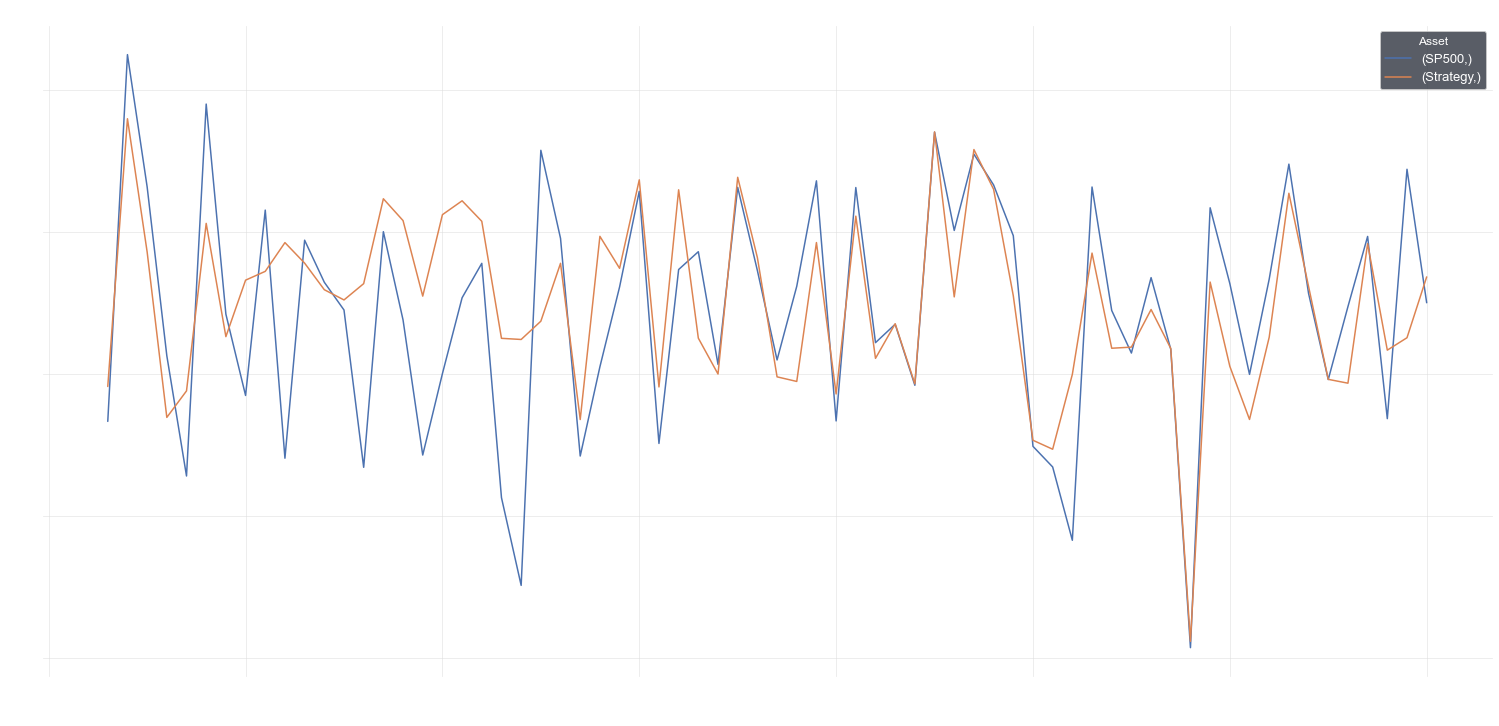

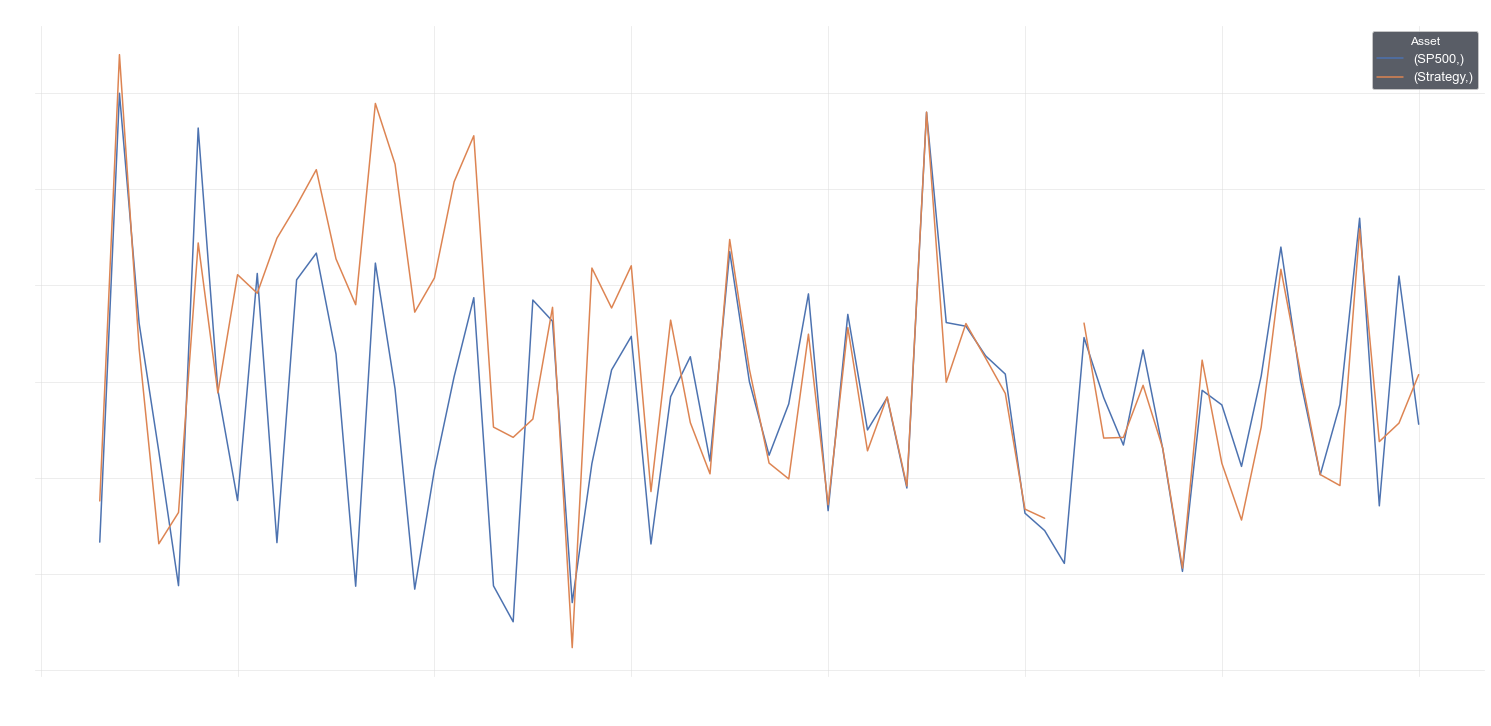

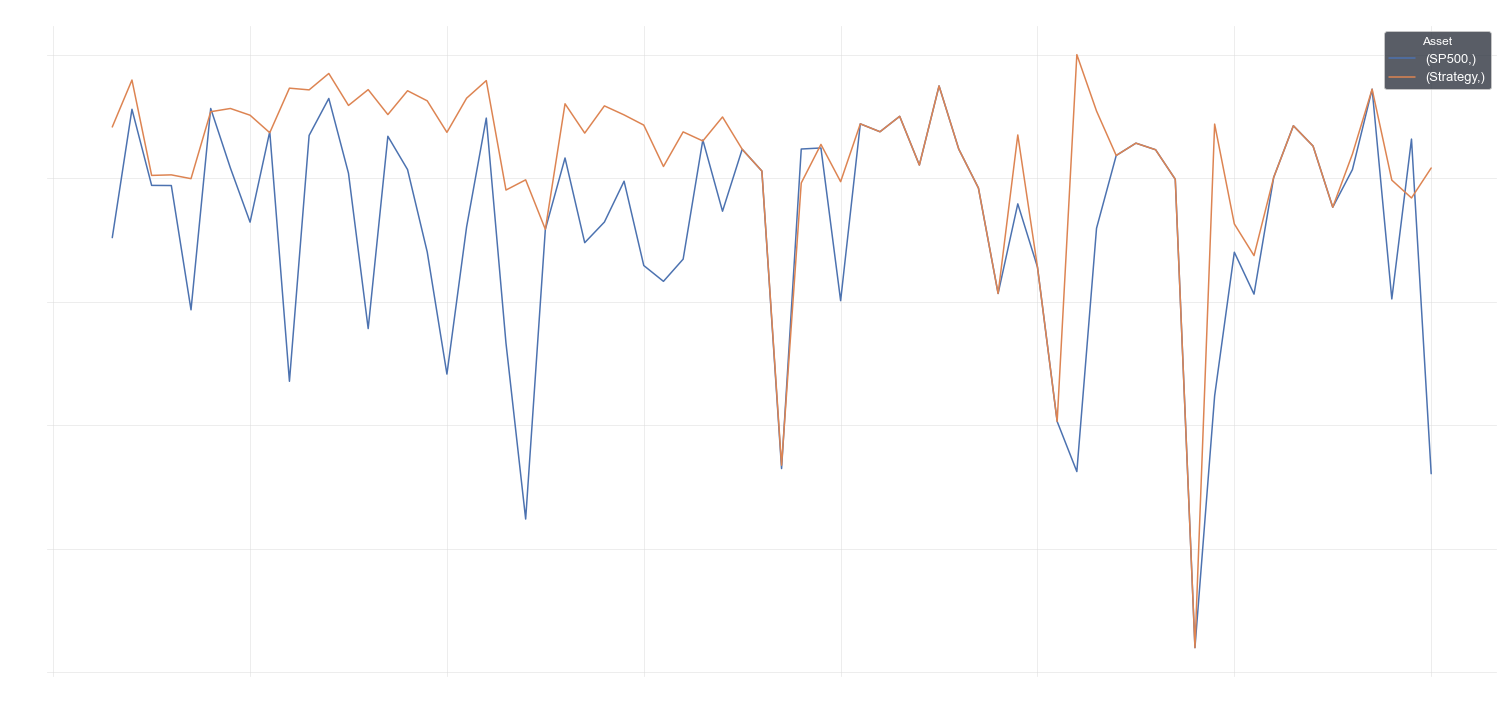

In [20]:
metrics_df.xs('PNL', axis=1, level=1)
metrics_df.xs('PNL', axis=1, level=1).T.plot(title="PNL of Strategy vs Benchmark (1953-2020)")
metrics_df.xs('SR', axis=1, level=1).T.plot(title="SR of Strategy vs Benchmark (1953-2020)")
metrics_df.xs('MAX_DD', axis=1, level=1).T.plot(title="MAX_DD of Strategy vs Benchmark (1953-2020)")

In [20]:
#metrics_df.xs('Strategy', axis=0).round(3).to_clipboard(sep=',')
#metrics_df.xs('Strategy', axis=0).T.sort_index().round(3).to_clipboard(sep=',')
#metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index().round(3).to_clipboard(sep=',')

#metrics_df.round(3).to_csv("metrics.csv", sep=';')

In [21]:
#by column: metrics_df.xs('PNL', axis=1, level='Metric')
#metrics_df.xs('PNL', axis=1, level=1) 
#metrics_df.xs('SP500', axis=0) #by index
#metrics_df.loc['SP500', (2013, 'PNL')]
#met = metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index()
#met

## Analysis of OOS performance

### HTML Reports 

In [22]:
%run Functions.ipynb
html_df = results_df.copy()
html_df.iloc[[0,-1]]

,Close,Market_daily_ret,Strat_daily_ret,Strat_position,Long_only,Costs,Market_cum_ret,Strat_cum_ret
1953-01-02,26.540001,-0.001129,-0.000112,1,0,0.000111538,99.887095,99.988846
2020-06-01,3058.600098,0.004694,0.004694,1,0,0,11511.479612,38786.309717


#### Strategy

#### Benchmark

### Annualized returns

###  Overall performance (PNL and SR)

In [108]:
n_years = OOS_start_years[-1].year - OOS_start_years[0].year + 1

# overall_ret_sp = (results_df.at[results_df.index.max(), 'Close'] - results_df.at[results_df.index.min(), 'Close']) / results_df.at[results_df.index.min(), 'Close']
# overall_ret_sp
overall_ret_sp = (results_df.at[results_df.index.max(), 'Market_cum_ret'] - results_df.at[results_df.index.min(), 'Market_cum_ret']) / results_df.at[results_df.index.min(), 'Market_cum_ret']
overall_ret_strat = (results_df.at[results_df.index.max(), 'Strat_cum_ret'] - results_df.at[results_df.index.min(), 'Strat_cum_ret']) / results_df.at[results_df.index.min(), 'Strat_cum_ret']
annualized_ret_sp = (1 + overall_ret_sp)**(1/n_years) - 1
annualized_ret_strat = (1 + overall_ret_strat)**(1/n_years) - 1

print("Overall OOS performace:")
print("\t\tMarket\tStrategy\nOverall ret:\t{:.2f}\t{:.2f}\nAnnualized:\t{:.3f} %\t{:.3f} %".format(overall_ret_sp, overall_ret_strat, 
                                           annualized_ret_sp*100, annualized_ret_strat*100))
print("Average PNL:\t{:.2f}\t{:.2f}".format(np.mean(market_pln), np.mean(oos_pln)))
print("SR:\t\t{:.2f}\t{:.2f}".format(results_df['Market_daily_ret'].sharpe(), results_df['Strat_daily_ret'].sharpe()))

Overall OOS performace:
		Market	Strategy
Overall ret:	114.24	386.91
Annualized:	7.230 %	9.162 %
Average PNL:	108.59	109.92
SR:		0.53	0.78
